In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import warnings
warnings.filterwarnings('ignore')

import data_util as du

In [124]:
file = "data/combined_milas_hall/Flo2.3-A2-33.csv"
df = pd.read_csv(file)
df.head()

,timestamp,DprPos,FlSpt,HwVlvPos,RmTmp,RmTmpCspt,RmTmpHpst,SaFl
0,2020-10-09 13:30:00,23.15625,400.0,32.812500,64.382812,85.0,65.0,396.0
1,2020-10-09 13:45:00,23.15625,400.0,26.171875,64.585938,85.0,65.0,395.0
2,2020-10-09 14:00:00,23.15625,400.0,21.093750,64.578125,85.0,65.0,396.0
3,2020-10-09 14:15:00,23.15625,400.0,26.562500,64.468750,85.0,65.0,397.0
4,2020-10-09 14:30:00,23.15625,400.0,22.265625,64.640625,85.0,65.0,397.0


In [125]:
df.isnull().sum()

timestamp    0
DprPos       0
FlSpt        0
HwVlvPos     0
RmTmp        0
RmTmpCspt    0
RmTmpHpst    0
SaFl         0
dtype: int64

There doesn't seem to any null values

#### Basic Visualization

In [ ]:
df = du.timestamp_split(file)
df.head()

,DprPos,FlSpt,HwVlvPos,RmTmp,RmTmpCspt,RmTmpHpst,SaFl,datetime
0,23.15625,400.0,32.812500,64.382812,85.0,65.0,396.0,2020-10-09 13:30:00
1,23.15625,400.0,26.171875,64.585938,85.0,65.0,395.0,2020-10-09 13:45:00
2,23.15625,400.0,21.093750,64.578125,85.0,65.0,396.0,2020-10-09 14:00:00
3,23.15625,400.0,26.562500,64.468750,85.0,65.0,397.0,2020-10-09 14:15:00
4,23.15625,400.0,22.265625,64.640625,85.0,65.0,397.0,2020-10-09 14:30:00


Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

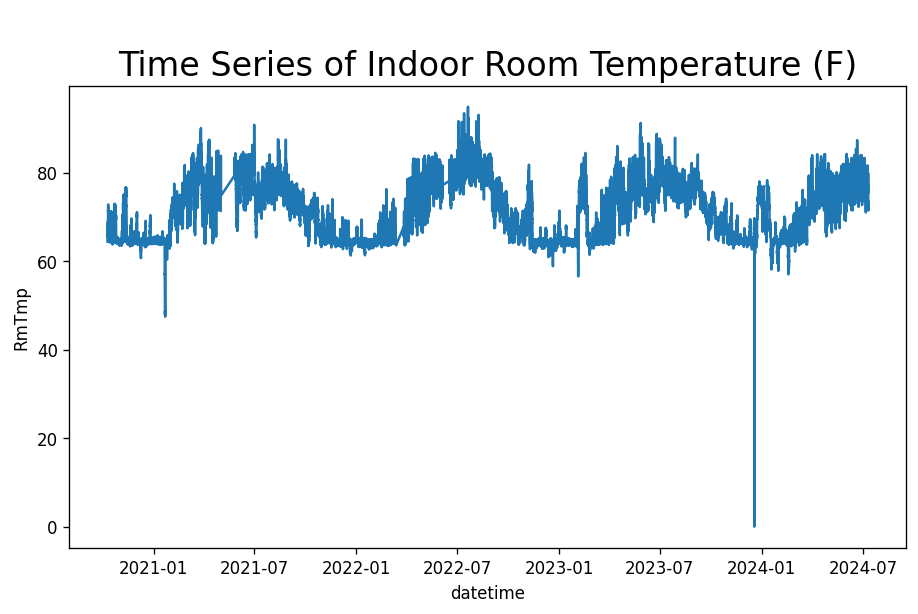

In [135]:
ax = sns.lineplot(data=df, x="datetime", y="RmTmp")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

#### Downsampling
Smooth out data to remove hourly fluctuations and see more seasonal changes. From here, we can see
that there is a cycle that occurs  yearly basis. 

Text(0.5, 1.0, '\nAggregated Daily Temperature (F)')

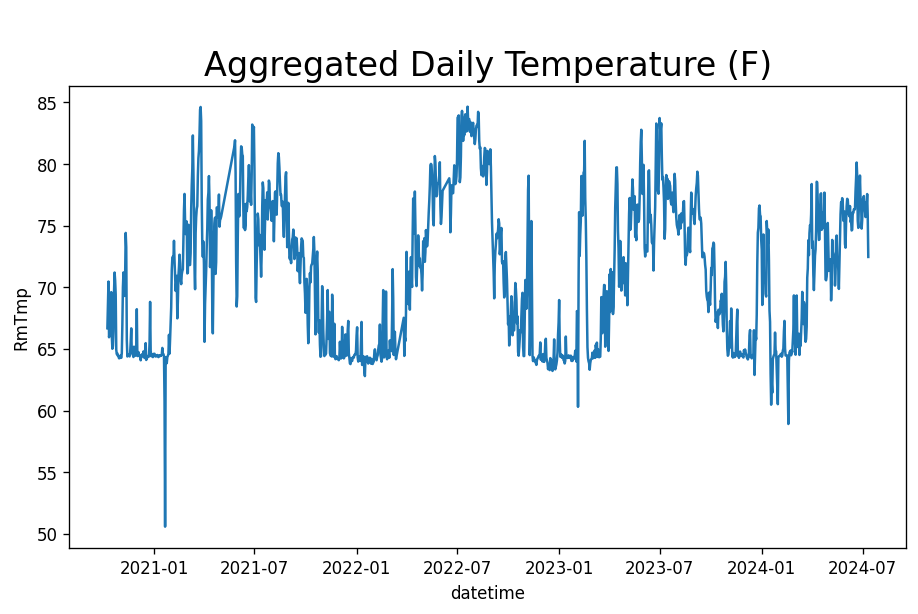

In [137]:
downsample_df = df.resample(rule="D", on="datetime").mean()
ax = sns.lineplot(data=downsample_df, x="datetime", y="RmTmp")
ax.axes.set_title("\nAggregated Daily Temperature (F)", fontsize=20)

#### Check for Stationary Data
Some models assume that the data is stationary, meaning that there is a constant mean (not time-dependent), constant variance (not time-dependent), and constant covariance (not time-dependent). We can try to check for this visually.

<AxesSubplot:xlabel='datetime', ylabel='RmTmp'>

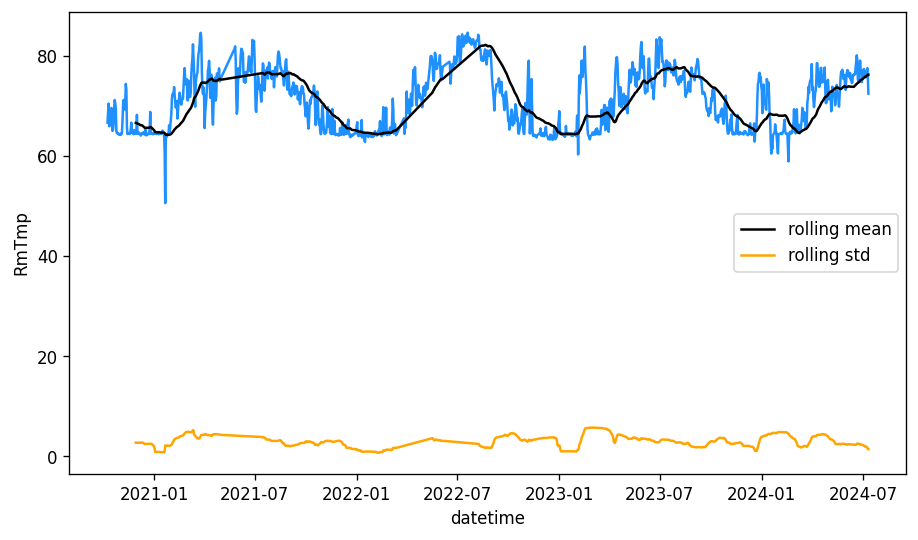

In [139]:
from pandas.plotting import autocorrelation_plot

rolling_window = 52 # 52 weeks per year

sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"], color="dodgerblue")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).mean(), color="black", label="rolling mean")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).std(), color="orange", label="rolling std")

ADF (Augmented Dickery-Fuller) test (null hypothesis is that the time series has a unit root (is not stationary). any p-value less than 0.05 means we can reject this and that the series IS stationary.)

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["RmTmp"].values, autolag="AIC")
print(f"ADF Statistic Value: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"    {key}: {value}")


Based on this, since the p-value is close to 0 (statistical value < critical value>), the result is statistically significant and the series is stationary. This means any transformation is not necessary.

#### White Noise Test (Autocorrelation)
White noise is completely random with a mean of 0 with no pattern. We can check for this by looking at autocorrelation. In a white noise series, autocorrelation should be close to 0. 